**1. Importing libraries and Dataset**

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('sales_data.csv')

**2. TASK 1: Data Cleaning**

In [20]:
# Handle missing values by filling with placeholder values (could be replaced with mean or mode as per need)
df.fillna({'Quantity': 0, 'Total Amount': 0}, inplace=True)

# Standardize the date format, but using a custom function instead of directly using pd.to_datetime
def standardize_date(date):
    try:
        return datetime.strptime(date, '%Y-%m-%d')
    except:
        return np.nan  # Handle any conversion errors with NaN
df['Order Date'] = df['Order Date'].apply(standardize_date)

# Drop duplicate rows using a custom function
df = df.loc[~df.duplicated()]

# Ensure numerical columns have correct data types
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0)
df['Total Amount'] = pd.to_numeric(df['Total Amount'], errors='coerce').fillna(0)

# Clean the dataset by removing invalid entries
df = df[df['Quantity'] > 0]

**3. TASK2: Customer Segmentation Dataframe Preparation**

In [21]:
# Create a dataframe for customer segmentation
customer_seg = pd.DataFrame({'Customer ID': df['Customer ID'].unique()})

# Calculate Recency using a custom lambda function to find the difference
current_date = datetime.now()
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Recency'] = (current_date - df['Order Date']).dt.days

# Calculate Recency for each customer
customer_recency = df.groupby('Customer ID')['Recency'].min()
customer_seg = customer_seg.merge(customer_recency, on='Customer ID')

# Calculate Frequency using value_counts instead of groupby size
customer_frequency = df['Customer ID'].value_counts()
customer_seg = customer_seg.merge(customer_frequency.rename('Frequency'), on='Customer ID')

# Calculate Monetary Value with sum but using the agg function
customer_monetary = df.groupby('Customer ID').agg({'Total Amount': 'sum'}).rename(columns={'Total Amount': 'Monetary'})
customer_seg = customer_seg.merge(customer_monetary, on='Customer ID')

# Use cut for Recency, Frequency, and Monetary to segment into 5 bins
# Recency (lower is better, so we invert the labels)
customer_seg['R_score'] = pd.cut(customer_seg['Recency'], bins=5, labels=[5, 4, 3, 2, 1]).astype(int)

# Frequency and Monetary (higher is better)
customer_seg['F_score'] = pd.cut(customer_seg['Frequency'], bins=5, labels=[1, 2, 3, 4, 5]).astype(int)
customer_seg['M_score'] = pd.cut(customer_seg['Monetary'], bins=5, labels=[1, 2, 3, 4, 5]).astype(int)


**CUSTOMER SEGMENTATION**

In [22]:
# Segment customers based on new conditions
def segment_customer(df):
    if df['R_score'] >= 3 and df['M_score'] >= 3 : # High Recency and Monetary
        return 'High-Value Customer'
    elif df['R_score'] < 3 and df['M_score'] > 3:  # High Monetary but low Recency
        return 'Big Spender'
    elif df['R_score'] > 3:  # High Recency
        return 'Recent Customer'
    elif df['R_score'] < 3:  # Low Recency
        return 'At-Risk Customer'
    else:
        return 'Other'

# Apply segmentation
customer_seg['Customer Segment'] = customer_seg.apply(segment_customer, axis=1)

### Bar Chart for customer segments distribution ###

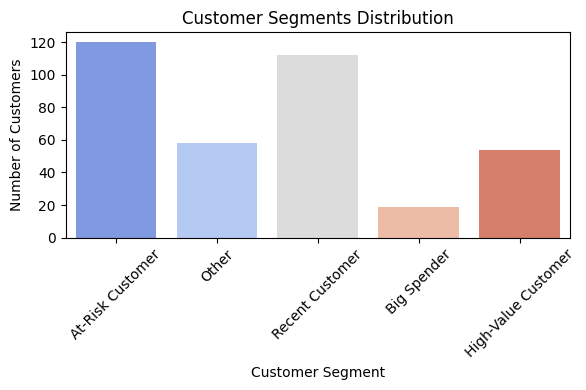

In [23]:

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'customer_seg' is your DataFrame and 'Customer Segment' is a column in it

plt.figure(figsize=(6, 4))
sns.countplot(x='Customer Segment', data=customer_seg, palette='coolwarm')
plt.title('Customer Segments Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**4. TASK4: Sales Trend Analysis**

In [24]:
#Initializing Sales Dataframe
sales_df = df.copy()
sales_df = sales_df.drop(columns=['Customer ID', 'Order ID',
       'Recency'])

In [25]:
# Convert 'Order Date' to datetime for easy grouping and analysis
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'])

# Extract year and month for analysis
sales_df['Year'] = sales_df['Order Date'].dt.year
sales_df['Month'] = sales_df['Order Date'].dt.month

# 1. Monthly Sales Trend
monthly_sales = sales_df.groupby(['Year', 'Month'])['Total Amount'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(Day=1))  # Combine year and month into a date
monthly_sales = monthly_sales[['Date', 'Total Amount']].sort_values('Date')

# 2. Yearly Sales Trend
yearly_sales = sales_df.groupby('Year')['Total Amount'].sum().reset_index()

# 3. Best Performing Product Categories
category_performance = sales_df.groupby('Category')['Total Amount'].sum().reset_index().sort_values(by='Total Amount', ascending=False)

# 4. Regions with Highest Sales
region_sales = sales_df.groupby('Region')['Total Amount'].sum().reset_index().sort_values(by='Total Amount', ascending=False)

### Line Chart for monthly and yearly sales trend ###

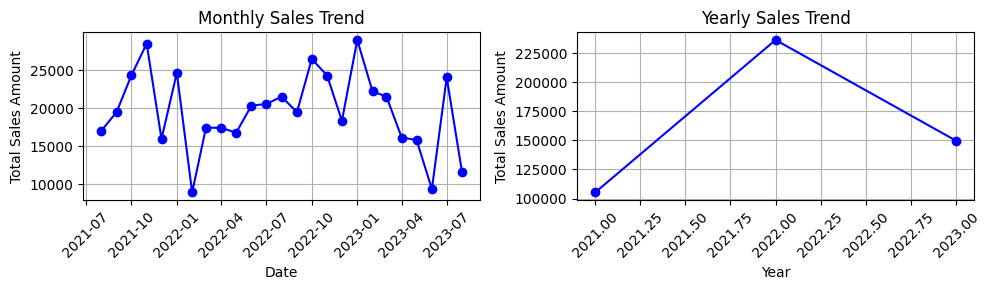

In [26]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# 1. Line Chart for Monthly Sales Trend
ax[0].plot(monthly_sales['Date'], monthly_sales['Total Amount'], marker='o', color='b')
ax[0].set_title('Monthly Sales Trend')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total Sales Amount')
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

# 2. Line Chart for Yearly Sales Trend
ax[1].plot(yearly_sales['Year'], yearly_sales['Total Amount'], marker='o', color='b')
ax[1].set_title('Yearly Sales Trend')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Total Sales Amount')
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

# Display the subplots
plt.show()


### Bar Chart for top prodect categories ###

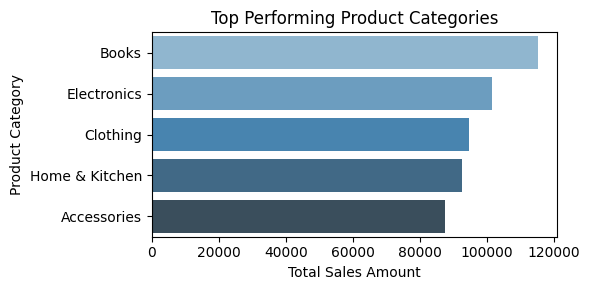

In [27]:

plt.figure(figsize=(6, 3))
sns.barplot(x='Total Amount', y='Category', data=category_performance, palette='Blues_d')
plt.title('Top Performing Product Categories')
plt.xlabel('Total Sales Amount')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


### Pie Chart for regional sales distribution ###

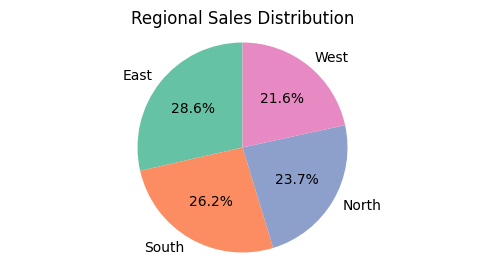

In [28]:

plt.figure(figsize=(6, 3))
plt.pie(region_sales['Total Amount'], labels=region_sales['Region'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Regional Sales Distribution')
plt.axis('equal')  # Ensures that pie chart is drawn as a circle
plt.show()
